This notebook does the following:

1. as
2. 

## Data loading

In [1]:
import pandas as pd
import yaml
from pathlib import Path
import numpy as np

with open("../data/processed/finbenthic/trained_models.yaml", "r") as f:
    config = yaml.safe_load(f)


In [2]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from scipy.spatial.distance import cdist
import subprocess

def is_outlier(s, label):
    if s == label:
        return True
    return False

def load_data(label, model_name):
    model_stem = Path(model_name).stem

    # Load dataframe. This contains the classifier predictions for each image
    df_pred0 = pd.read_csv(f"../predictions/preds_{model_stem}_none.csv")
    n_col = df_pred0.shape[1]-2

    # Load the reference dataframe. This contains the train test splits
    df_ref = pd.read_csv(f"../data/processed/finbenthic/leave-one-out/02_finbenthic2_outliers_{label}.csv")

    # Split the reference to test and train sets. Test set is combined with the predictions. Train set is not used
    df_ref_test = df_ref[df_ref["0"] == "test"].reset_index(drop=True)
    # df_ref_train = df_ref[df_ref["0"] == "train"].reset_index(drop=True)

    # Get the image filenames from df_ref_test and combine with predictions
    df_pred = pd.concat((df_ref_test[["img"]], df_pred0), axis=1).set_index("img")

    # Set a ground truth boolean whether the image is in the outlier class
    df_pred = df_pred.assign(is_outlier = df_pred["y_true"].map(lambda x: is_outlier(x, label))*1)
    assert (df_pred0.y_true == df_ref_test.taxon).all()

    return df_pred, n_col

def align_dna(fname):
    metabc_sample = pd.read_csv(fname).set_index("taxon")

    # Turn to SeqRecord format
    records = []
    for i, row in metabc_sample.iterrows():
        record = SeqRecord(
            Seq(row.seq),
            id=row.name
        )
        records.append(record)

    # Write to FASTA
    with open("otus_fb2.fasta", "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")

    # Align sequences with muscle
    subprocess.run([r"..\muscle.exe",
                        "-align", "otus_fb2.fasta", 
                        "-output", "otus_fb2_align.fasta"])
    # Load the aligned sequences and add them to the dataframe
    aligned = [x for x in SeqIO.parse("otus_fb2_align.fasta", "fasta")]
    for a in aligned:
        metabc_sample.loc[a.id, "seq_align"] = str(a.seq)
    metabc_sample
    return metabc_sample

def jaccard(a,b):
    a = np.array([x for x in a])
    b = np.array([x for x in b])
    return np.sum(a == b)/len(a)

def calculate_distance_matrix(df):
    # Create a list of id-sequence pairs
    seqs = []
    for i,row in df.iterrows():
        seqs.append({"id": row.name,
                    "seq": row.seq_align})

    # Calculate a distance matrix for all sequences
    D = pd.DataFrame(index=metabc_sample.index, columns=metabc_sample.index)
    for s1 in seqs:
        for s2 in seqs:
            d = jaccard(s1["seq"], s2["seq"])
            D.loc[s1["id"], s2["id"]] = d
    D = 1-D.astype(np.float64)
    return D
    
metabc_sample = align_dna("../data/raw/fb2dna.csv")
metabc_sample


C:\Users\E1007914\AppData\Local\Temp\ipykernel_31616\3212998547.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AACTATTTATTTTATTTTTGGAATTTGATCTGGAATAGTAGGAACTTCTCTAAGAATAATTATTCGAACTGAGCTAGGGACTGCTGAATCTTTAATTAAAAATGATCAAATTTATAATGTTTTAGTGACAGCTCATGCTTTTATTATAATTTTTTTTATAGTTATACCTATTATAATTGGGGGGTTCGGAAACTGATTAGTCCCCCTAATAATTGGAGCTCCAGATATAGCTTTTCCTCGGATAAATAATATAAGATTTTGATTTTTACCCCCCTCATTAAATTTTTTATTAATTAGATCTTTTATTGAGAGAGGAACCGGTACAGGATGAACTGTATACCCGCCCTTATCCAGAAATTTAGCTCATGCCGGAAGATCGGTAGATATCTCTATTTTTTCTTTACATTTAGCTGGAATTTCTTCTATTTTAGGGGCTATTAATTTTATTTCAACCACCCTAAACATACGAAGAAAATTAATTTCTCTAGACCGAATTCCCCTATTTGTTTGATCAGTTGCTATTACTGCACTTCTTTTATTATTATCTCTTCCCGTATTAGCAGGAGCTATTACCATACTATTAACTGATCGAAATTTAAATACTTCTTTTTTTGACCCCTCAGGGGGGGGGGACCCTATTTTATACCAACATTTATTT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metabc_sample.loc[a.id, "seq_align"] = str(a.seq)


,bold_record,seq,seq_align
taxon,,,
Agapetus_sp,TRIFI570-11,AACGTTATATTTCATTTTTGGAATTTGAAGAGGTATAGTAGGAACT...,AACGTTATATTTCATTTTTGGAATTTGAAGAGGTATAGTAGGAACT...
Ameletus_inopinatus,FIEPT199-16,CACTCTTTATTTTATTTTTGGGGCATGAGCTGGAATGGTGGGGACT...,CACTCTTTATTTTATTTTTGGGGCATGAGCTGGAATGGTGGGGACT...
Amphinemura_borealis,TRIFI1309-16,AACTCTTTACTTCATTTTCGGAGCTTGATCCGGAATAGTCGGGACT...,AACTCTTTACTTCATTTTCGGAGCTTGATCCGGAATAGTCGGGACT...
Baetis_rhodani,FIEPT203-16,TACTCTATATTTCATTTTTGGTGCTTGGGCAGGTATGGTAGGGACC...,TACTCTATATTTCATTTTTGGTGCTTGGGCAGGTATGGTAGGGACC...
Baetis_vernus_group,FIEPT207-16,TACGTTATATTTTATTTTCGGTGCCTGATCGGGTATAGTAGGAACG...,TACGTTATATTTTATTTTCGGTGCCTGATCGGGTATAGTAGGAACG...
Capnopsis_schilleri,FIEPT283-16,AACATTATATTTTATCTTTGGAGCTTGGGCAGGGATAGTAGGAACT...,AACATTATATTTTATCTTTGGAGCTTGGGCAGGGATAGTAGGAACT...
Diura_sp,FIEPT060-11,TACACTATACTTTATTTTTGGAGCATGATCTGGAATAGTAGGGACT...,TACACTATACTTTATTTTTGGAGCATGATCTGGAATAGTAGGGACT...
Elmis_aenea,COLFF808-13,AACACTTTATTTTATTCTAGGATCATGATCAGGAATGTTAGGAATA...,AACACTTTATTTTATTCTAGGATCATGATCAGGAATGTTAGGAATA...
Ephemerella_aurivillii,EPHFI036-11,AACTTTATATTTCATTTTTGGGGCATGATCAGGTATAGTGGGGACT...,AACTTTATATTTCATTTTTGGGGCATGATCAGGTATAGTGGGGACT...


In [11]:
def process_distance_matrix(D0):
    D = D0.copy()
    D.index = [x.replace("<unknown description>", "").strip() for x in D.index]
    D.columns = [x.replace("<unknown description>", "").strip() for x in D.columns]
    return D[sorted(D.columns)].sort_index()

D_jc69 = pd.read_csv("../scripts/jc69.csv")
D_k80 = pd.read_csv("../scripts/k80.csv")

D = {}
D["jc69"] = process_distance_matrix(D_jc69)
D["k80"] = process_distance_matrix(D_k80)
D["jaccard"] = calculate_distance_matrix(metabc_sample)
D["k80"]

,Agapetus_sp,Ameletus_inopinatus,Amphinemura_borealis,Baetis_rhodani,Baetis_vernus_group,Capnopsis_schilleri,Diura_sp,Elmis_aenea,Ephemerella_aurivillii,Ephemerella_mucronata,...,Plectrocnemia_sp,Polycentropus_flavomaculatus,Polycentropus_irroratus,Protonemura_sp,Rhyacophila_nubila,Sialis_sp,Silo_pallipes,Simuliidae,Sphaerium_sp,Taeniopteryx_nebulosa
Agapetus_sp,0.000000,0.303350,0.300392,0.355474,0.368173,0.330540,0.328199,0.294684,0.265572,0.316057,...,0.313629,0.319989,0.373838,0.341676,0.242463,0.297018,0.277235,0.247665,0.488609,0.280274
Ameletus_inopinatus,0.303350,0.000000,0.251670,0.259005,0.304620,0.244326,0.240408,0.306145,0.218692,0.245251,...,0.367866,0.399649,0.425362,0.253749,0.272601,0.220242,0.344400,0.232682,0.478129,0.227334
Amphinemura_borealis,0.300392,0.251670,0.000000,0.303350,0.310195,0.203172,0.234837,0.276651,0.271808,0.267613,...,0.374297,0.409785,0.410392,0.219931,0.237525,0.230001,0.289543,0.211626,0.443280,0.179710
Baetis_rhodani,0.355474,0.259005,0.303350,0.000000,0.221610,0.315583,0.337105,0.301378,0.314435,0.303534,...,0.393679,0.421177,0.448811,0.261364,0.327425,0.249913,0.331420,0.297617,0.411958,0.261963
Baetis_vernus_group,0.368173,0.304620,0.310195,0.221610,0.000000,0.325922,0.313243,0.307968,0.290873,0.280606,...,0.393679,0.434859,0.430693,0.262723,0.297617,0.296340,0.357651,0.296861,0.415303,0.266028
Capnopsis_schilleri,0.330540,0.244326,0.203172,0.315583,0.325922,0.000000,0.225605,0.280331,0.263397,0.292272,...,0.400200,0.444244,0.442479,0.226166,0.279332,0.244118,0.342915,0.246129,0.475064,0.185629
Diura_sp,0.328199,0.240408,0.234837,0.337105,0.313243,0.225605,0.000000,0.341898,0.260313,0.289561,...,0.418892,0.457823,0.435015,0.242449,0.299343,0.300465,0.389343,0.254663,0.489982,0.237365
Elmis_aenea,0.294684,0.306145,0.276651,0.301378,0.307968,0.280331,0.341898,0.000000,0.296095,0.323083,...,0.340126,0.383587,0.396172,0.270273,0.248248,0.248248,0.332948,0.262138,0.467231,0.241765
Ephemerella_aurivillii,0.265572,0.218692,0.271808,0.314435,0.290873,0.263397,0.260313,0.296095,0.000000,0.204173,...,0.382420,0.454639,0.455342,0.282133,0.281388,0.272767,0.324104,0.240650,0.468633,0.243382
Ephemerella_mucronata,0.316057,0.245251,0.267613,0.303534,0.280606,0.292272,0.289561,0.323083,0.204173,0.000000,...,0.369174,0.437575,0.429314,0.259211,0.319958,0.283561,0.351453,0.252498,0.425889,0.227470


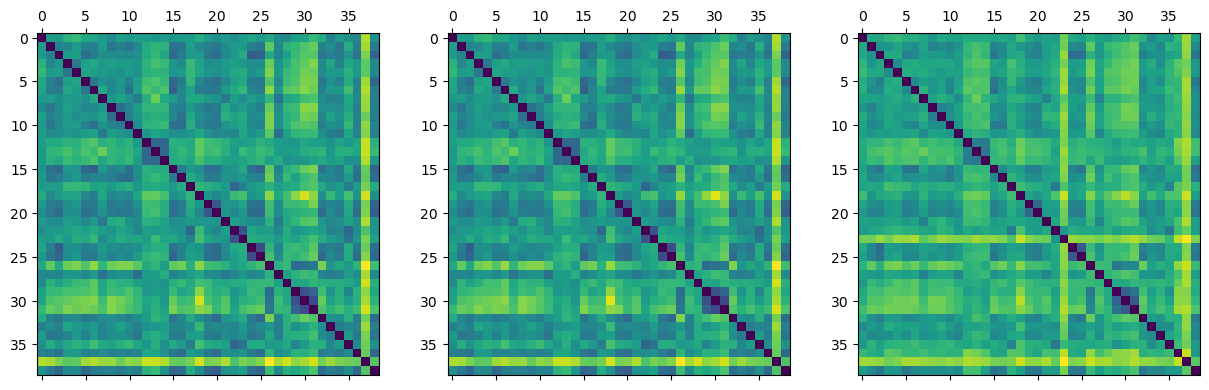

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].matshow(D["jc69"].values)
ax[1].matshow(D["k80"].values)
ax[2].matshow(D["jaccard"].values)

## Computations

In [46]:
# re_order_preds(label, D["k80"], df_pred, "H")
D["k80"].loc[label].sort_values().drop(label)

Agapetus_sp                     0.260711
Hydropsyche_siltalai            0.277560
Hydropsyche_pellucidula         0.293511
Hydropsyche_saxonica            0.305027
Simuliidae                      0.305980
Hydraena_sp                     0.316057
Amphinemura_borealis            0.316995
Oulimnius_tuberculatus          0.319397
Polycentropus_flavomaculatus    0.328300
Plectrocnemia_sp                0.331004
Elmis_aenea                     0.331634
Limnius_volckmari               0.332577
Silo_pallipes                   0.334237
Lepidostoma_hirtum              0.338754
Leuctra_sp                      0.339730
Micrasema_gelidum               0.339803
Micrasema_setiferum             0.343291
Sialis_sp                       0.344020
Rhyacophila_nubila              0.346066
Protonemura_sp                  0.347155
Baetis_rhodani                  0.348772
Isoperla_sp                     0.351200
Taeniopteryx_nebulosa           0.352289
Ephemerella_mucronata           0.356187
Heptagenia_sulph

In [47]:
def calc_classifier_metrics(df_pred, n_col):
    """Calculate the classification entropy from predictions and adds them to the end of the dataframe"""
    predX = df_pred.values[:,2:n_col].astype(np.float64)
    H = -np.sum(predX*np.log(predX),axis=1)
    df_pred["H"] = H
    # Calculate the ratio between max probable class and the second most probable
    largest = predX.max(axis=1)
    second_largest = np.partition(predX, -2, axis=1)[:, -2]
    r = second_largest/largest
    df_pred["r"] = r
    return df_pred

def re_order_preds(label, D, df_pred, sorting_key):
    """Re-orders predictions based on the proximity matrix D"""

    candidate_order = D.loc[label].sort_values(ascending=True).drop(label)
    block_list = []
    for candidate in candidate_order.index:
        block = df_pred.sort_values(sorting_key, ascending=False).query("y_pred == @candidate")[[sorting_key, "is_outlier"]]
        block_list.append(block)

    sorted_df_dna = pd.concat(block_list)
    return sorted_df_dna

def re_order_quantile(label, D, df_pred, sorting_key):
    """Re-orders predictions in two parts: first the top 80 quantile of sorting_key values
    and after that the last 20 quantile"""

    q = df_pred[sorting_key].quantile(0.8)
    sorted = df_pred.sort_values(sorting_key, ascending=False)
    over_threshold = sorted[sorted[sorting_key]>q]
    under_threshold = sorted[sorted[sorting_key]<=q]

    return pd.concat((re_order_preds(label, D, over_threshold, sorting_key),
               re_order_preds(label, D, under_threshold, sorting_key)), axis=0)

def calculate_dfs_from_distances(label, df_pred, D):
    sorted_dfs = {}
    sorted_dfs["dna"] = {}
    sorted_dfs["dna"]["H"] = re_order_preds(label, D, df_pred, "H")
    sorted_dfs["dna"]["r"] = re_order_preds(label, D, df_pred, "r")

    sorted_dfs["dna_quantile"] = {}
    sorted_dfs["dna_quantile"]["H"] = re_order_quantile(label, D, df_pred, "H")
    sorted_dfs["dna_quantile"]["r"] = re_order_quantile(label, D, df_pred, "r")
    return sorted_dfs

def calculate_all_dfs(label, df_pred, D):
    sorted_dfs = {}
    sorted_dfs["by_cnn"] = {}
    sorted_dfs["by_cnn"]["H"] = df_pred.sort_values(by="H", ascending=False)[["H", "is_outlier"]]
    sorted_dfs["by_cnn"]["r"] = df_pred.sort_values(by="r", ascending=False)[["r", "is_outlier"]]

    sorted_dfs["by_dna"] = {}
    for key in D.keys():
        sorted_dfs["by_dna"][key] = {}
        sorted_dfs["by_dna"][key] = calculate_dfs_from_distances(label, df_pred, D[key])
    sorted_dfs["y_pred"] = np.linspace(1,0, len(sorted_dfs["by_cnn"]["H"]))
    return sorted_dfs

In [48]:
label, model_name = next(iter(zip(config["labels"], config["ckpts"])))
label = "Oxyethira_sp"
model_name =  "outputs/finbenthic2/dnaimg_Oxyethira_sp_efficientnet_b0/f0/dnaimg_Oxyethira_sp_efficientnet_b0_f0_240111-0736-7249_epoch27_val-loss0.22.ckpt"

df_pred, n_col = load_data(label, model_name)
df_pred = calc_classifier_metrics(df_pred, n_col)
sorted_dfs = calculate_all_dfs(label, df_pred, D)
sorted_dfs

{'by_cnn': {'H':                                                                H  is_outlier
  img                                                                         
  0-Oxyethira122.2.2016-07-23-15-795819000000-utc...  2.497725e+00           1
  0-Oxyethira122.1.2016-07-23-15-620135000000-utc...  2.478822e+00           1
  0-Oxyethira122.1.2016-07-23-15-417720000000-utc...  2.462176e+00           1
  0-Oxyethira122.1.2016-07-23-15-776990000000-utc...  2.379376e+00           1
  0-Oxyethira165.1.2016-07-44-44-649614000000-utc...  2.356391e+00           1
  ...                                                          ...         ...
  0-Agapetus114.1.2016-10-19-16-276047000000-utc.png  1.510292e-13           0
  0-Agapetus114.1.2016-10-19-16-469097000000-utc.png  1.434576e-13           0
  1-Agapetus247.1.2016-12-04-53-239426000000-utc.png  1.257482e-13           0
  1-Agapetus247.1.2016-12-04-53-160174000000-utc.png  1.075267e-13           0
  1-Agapetus247.1.2016-12-04-52-94137

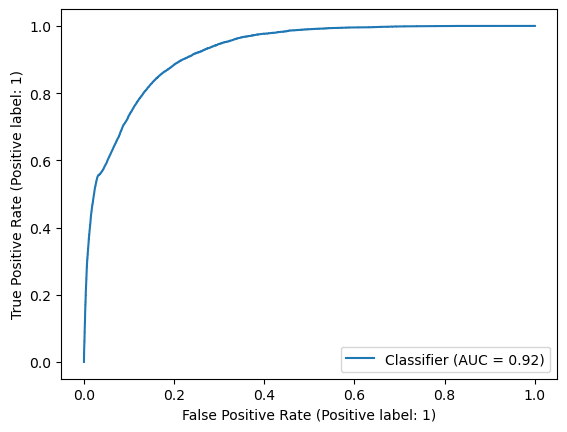

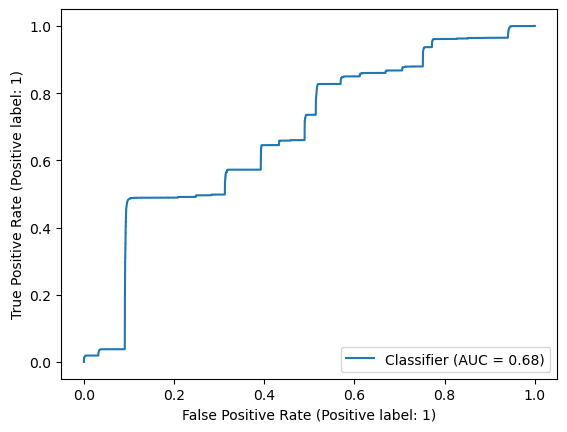

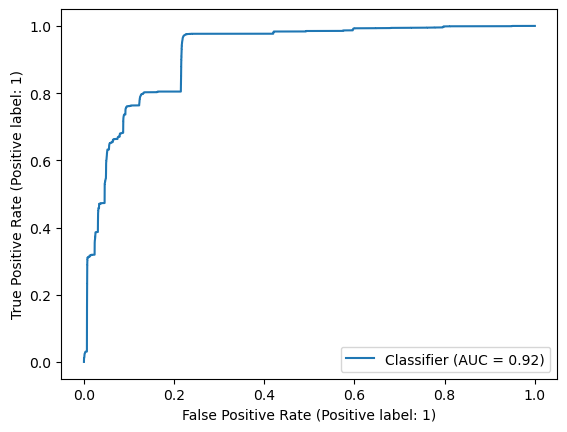

In [59]:
y_pred = sorted_dfs["y_pred"] 
from sklearn.metrics import RocCurveDisplay

cnn_metric = "H"
dna_distance = "k80"
RocCurveDisplay.from_predictions(
    sorted_dfs["by_cnn"][cnn_metric].is_outlier,
    y_pred
)
RocCurveDisplay.from_predictions(
    sorted_dfs["by_dna"][dna_distance]["dna"][cnn_metric].is_outlier,
    y_pred
)
RocCurveDisplay.from_predictions(
    sorted_dfs["by_dna"][dna_distance]["dna_quantile"][cnn_metric].is_outlier,
    y_pred
)

In [110]:
from sklearn.metrics import roc_auc_score, average_precision_score

def calc_metrics(sorted_df):
    y_pred = np.linspace(1,0, len(sorted_df))
    auc = roc_auc_score(
        sorted_df.is_outlier,
        y_pred
    )
    ap = average_precision_score(
        sorted_df.is_outlier,
        y_pred
    )

    return {"auc": auc, "ap":ap}
def calc_all_metrics(sorted_dfs):
    m_list = []

    # The ordered sequences based only cnn:s have different amount of keys
    # and are calculated separately from the dna ordered sequences
    for cnn_metric in sorted_dfs["by_cnn"].keys():
        m = {"type": "cnn",
             "dna_distance": None,
             "method": None,
             "cnn_metric": cnn_metric}
        m.update(calc_metrics(sorted_dfs["by_cnn"][cnn_metric]))
        m_list.append(m)

    for dna_distance in sorted_dfs["by_dna"].keys():
        dna_dfs = sorted_dfs["by_dna"][dna_distance]
        for method in dna_dfs.keys():
            method_dfs = dna_dfs[method]
            for cnn_metric in method_dfs.keys():
                m = {"type": "dna",
                     "dna_distance": dna_distance,
                     "method": method,
                     "cnn_metric": cnn_metric}
                m.update(calc_metrics(sorted_dfs["by_dna"][dna_distance][method][cnn_metric]))
                m_list.append(m)

    return pd.DataFrame(m_list)

metric_df = calc_all_metrics(sorted_dfs)
metric_df.query("method=='dna_quantile' and cnn_metric=='H'")

,type,dna_distance,method,cnn_metric,auc,ap
4,dna,jc69,dna_quantile,H,0.859132,0.492952
8,dna,k80,dna_quantile,H,0.859129,0.492935
12,dna,jaccard,dna_quantile,H,0.898622,0.557371


In [91]:
from tqdm.notebook import tqdm
metric_dfs = []
for label, model_name in tqdm(zip(config["labels"], config["ckpts"]), total=len(config["labels"])):
    df_pred, n_col = load_data(label, model_name)
    df_pred = calc_classifier_metrics(df_pred, n_col)
    sorted_dfs = calculate_all_dfs(label, df_pred, D)

    metric_df = calc_all_metrics(sorted_dfs)
    metric_df.insert(0, "label", label)
    metric_dfs.append(metric_df)
    print(label)

  0%|          | 0/39 [00:00<?, ?it/s]

Agapetus_sp
Ameletus_inopinatus
Amphinemura_borealis
Baetis_rhodani
Baetis_vernus_group
Capnopsis_schilleri
Diura_sp
Elmis_aenea
Ephemerella_aurivillii
Ephemerella_mucronata
Heptagenia_sulphurea
Hydraena_sp
Hydropsyche_pellucidula
Hydropsyche_saxonica
Hydropsyche_siltalai
Isoperla_sp
Kageronia_fuscogrisea
Lepidostoma_hirtum
Leptophlebia_sp
Leuctra_nigra
Leuctra_sp
Limnius_volckmari
Micrasema_gelidum
Micrasema_setiferum
Nemoura_cinerea
Nemoura_sp
Neureclipsis_bimaculata
Oulimnius_tuberculatus
Oxyethira_sp
Plectrocnemia_sp
Polycentropus_flavomaculatus
Polycentropus_irroratus
Protonemura_sp
Rhyacophila_nubila
Sialis_sp
Silo_pallipes
Simuliidae
Sphaerium_sp
Taeniopteryx_nebulosa


In [120]:
score_df = pd.concat(metric_dfs).melt(id_vars=["label", "type", "dna_distance", "method", "cnn_metric"], var_name="score")
score_df

,label,type,dna_distance,method,cnn_metric,score,value
0,Agapetus_sp,cnn,None,None,H,auc,0.923831
1,Agapetus_sp,cnn,None,None,r,auc,0.887685
2,Agapetus_sp,dna,jc69,dna,H,auc,0.371635
3,Agapetus_sp,dna,jc69,dna,r,auc,0.370936
4,Agapetus_sp,dna,jc69,dna_quantile,H,auc,0.781685
...,...,...,...,...,...,...,...
1087,Taeniopteryx_nebulosa,dna,k80,dna_quantile,r,ap,0.349322
1088,Taeniopteryx_nebulosa,dna,jaccard,dna,H,ap,0.438208
1089,Taeniopteryx_nebulosa,dna,jaccard,dna,r,ap,0.434306
1090,Taeniopteryx_nebulosa,dna,jaccard,dna_quantile,H,ap,0.557371


In [162]:
score_described = score_df.pivot(index="label", columns=["cnn_metric", "score", "type", "dna_distance", "method"])["value"]["r"].describe()
score_described.reorder_levels([0,3,1,2], axis=1)["auc"][[None,"dna_quantile"]]

method              NaN dna_quantile                      
type                cnn          dna                      
dna_distance        NaN         jc69        k80    jaccard
count         39.000000    39.000000  39.000000  39.000000
mean           0.798329     0.841381   0.841792   0.844563
std            0.089789     0.074870   0.074091   0.071535
min            0.532513     0.550468   0.550001   0.572665
25%            0.773467     0.817652   0.816735   0.816822
50%            0.810875     0.869873   0.869744   0.860066
75%            0.864956     0.893244   0.894233   0.896798
max            0.911115     0.919514   0.919520   0.919261

In [159]:
score_described

score               auc                                                  \
type                cnn        dna                                        
dna_distance        NaN       jc69                     k80                
method              NaN        dna dna_quantile        dna dna_quantile   
count         39.000000  39.000000    39.000000  39.000000    39.000000   
mean           0.826808   0.805912     0.870445   0.806602     0.870736   
std            0.094767   0.181902     0.052086   0.179750     0.051306   
min            0.560113   0.369306     0.759018   0.368527     0.758445   
25%            0.791480   0.748561     0.841816   0.751940     0.841959   
50%            0.844881   0.887146     0.888894   0.881978     0.890818   
75%            0.898932   0.937281     0.910761   0.936794     0.909644   
max            0.952894   0.984817     0.942343   0.984870     0.942343   

score                                        ap                          \
type                                        cnn        dna                
dna_distance    jaccard                     NaN       jc69                
method              dna dna_quantile        NaN        dna dna_quantile   
count         39.000000    39.000000  39.000000  39.000000    39.000000   
mean           0.816906     0.871601   0.359997   0.447750     0.461231   
std            0.179934     0.051433   0.238346   0.259368     0.231790   
min            0.348506     0.753476   0.006797   0.015474     0.020931   
25%            0.746774     0.837190   0.148536   0.245057     0.269839   
50%            0.886969     0.890647   0.354701   0.453502     0.526713   
75%            0.945601     0.909939   0.548543   0.640018     0.650258   
max            0.984412     0.940470   0.906733   0.903677     0.772834   

score                                                         
type                                                          
dna_distance        k80                 jaccard               
method              dna dna_quantile        dna dna_quantile  
count         39.000000    39.000000  39.000000    39.000000  
mean           0.445220     0.459613   0.445443     0.451487  
std            0.260872     0.232064   0.256218     0.230667  
min            0.015462     0.020866   0.014000     0.020767  
25%            0.241592     0.272651   0.289902     0.263306  
50%            0.474502     0.525550   0.446655     0.517521  
75%            0.640070     0.650557   0.667388     0.653763  
max            0.903691     0.773796   0.903246     0.769467

In [164]:
score_df

,label,type,dna_distance,method,cnn_metric,score,value
0,Agapetus_sp,cnn,None,None,H,auc,0.923831
1,Agapetus_sp,cnn,None,None,r,auc,0.887685
2,Agapetus_sp,dna,jc69,dna,H,auc,0.371635
3,Agapetus_sp,dna,jc69,dna,r,auc,0.370936
4,Agapetus_sp,dna,jc69,dna_quantile,H,auc,0.781685
...,...,...,...,...,...,...,...
1087,Taeniopteryx_nebulosa,dna,k80,dna_quantile,r,ap,0.349322
1088,Taeniopteryx_nebulosa,dna,jaccard,dna,H,ap,0.438208
1089,Taeniopteryx_nebulosa,dna,jaccard,dna,r,ap,0.434306
1090,Taeniopteryx_nebulosa,dna,jaccard,dna_quantile,H,ap,0.557371


82              Capnopsis_schilleri
432    Polycentropus_flavomaculatus
376         Neureclipsis_bimaculata
292                      Leuctra_sp
418                Plectrocnemia_sp
138           Ephemerella_mucronata
460                  Protonemura_sp
348                 Nemoura_cinerea
222                     Isoperla_sp
320               Micrasema_gelidum
390          Oulimnius_tuberculatus
362                      Nemoura_sp
334             Micrasema_setiferum
208            Hydropsyche_siltalai
180         Hydropsyche_pellucidula
236           Kageronia_fuscogrisea
544           Taeniopteryx_nebulosa
110                     Elmis_aenea
152            Heptagenia_sulphurea
40             Amphinemura_borealis
96                         Diura_sp
264                 Leptophlebia_sp
54                   Baetis_rhodani
250              Lepidostoma_hirtum
306               Limnius_volckmari
278                   Leuctra_nigra
124          Ephemerella_aurivillii
446         Polycentropus_ir

c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='value', ylabel='label'>

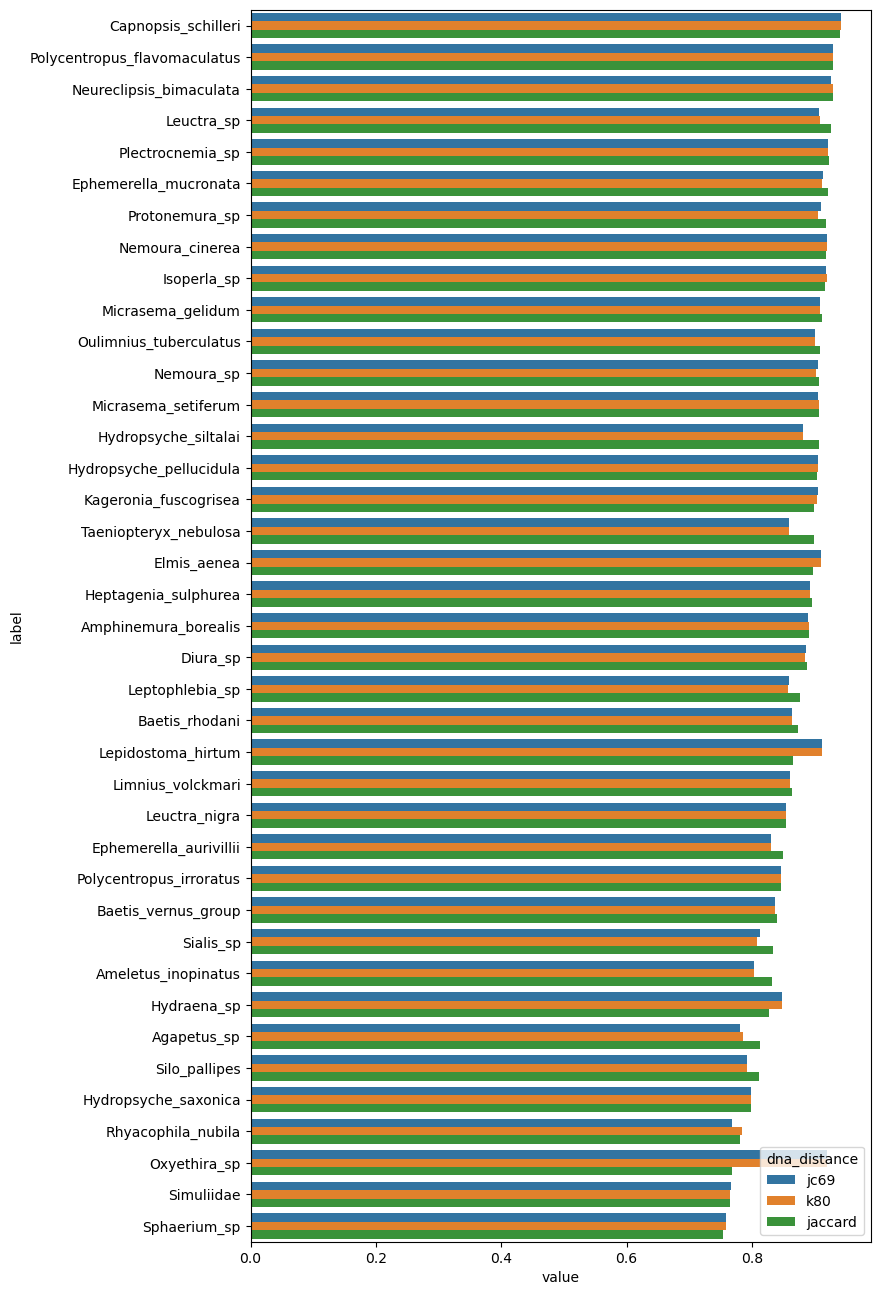

In [178]:
import seaborn as sns
plt.figure(figsize=(8, 16))
data = score_df.query("cnn_metric == 'H' and method=='dna_quantile' and score=='auc'")
order = data.query("dna_distance=='jaccard'").sort_values("value", ascending=False)["label"]
sns.barplot(data,
            x = "value",
            y = "label",
            hue="dna_distance",
            order=order)

c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='variable', ylabel='value'>

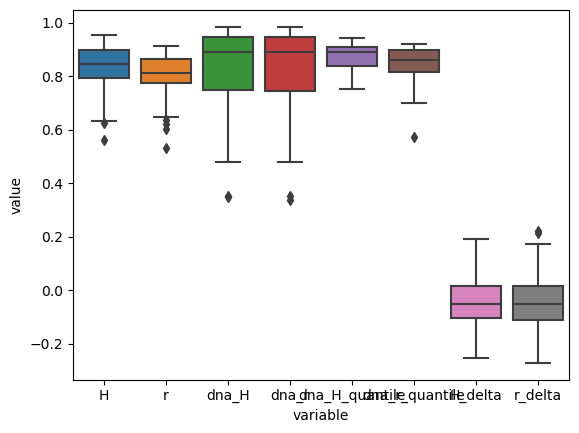

In [19]:
sns.boxplot(score_df.reset_index().melt(id_vars="index"),
            x = "variable",
            y = "value")

In [107]:
H_values["dna"]

dna_distance                      jc69                    k80               \
method                             dna dna_quantile       dna dna_quantile   
label                                                                        
Agapetus_sp                   0.371635     0.781685  0.380396     0.785907   
Ameletus_inopinatus           0.564046     0.803624  0.563627     0.803644   
Amphinemura_borealis          0.703484     0.888894  0.710264     0.890818   
Baetis_rhodani                0.809278     0.863207  0.809323     0.863209   
Baetis_vernus_group           0.916453     0.836939  0.917312     0.837224   
Capnopsis_schilleri           0.887146     0.942343  0.887146     0.942343   
Diura_sp                      0.943344     0.885494  0.942663     0.885381   
Elmis_aenea                   0.931138     0.910848  0.930924     0.910813   
Ephemerella_aurivillii        0.619505     0.830096  0.621438     0.830594   
Ephemerella_mucronata         0.816740     0.912734  0.815955     0.912485   
Heptagenia_sulphurea          0.840711     0.892284  0.839621     0.892017   
Hydraena_sp                   0.943939     0.847691  0.943939     0.847691   
Hydropsyche_pellucidula       0.974600     0.904930  0.974623     0.904917   
Hydropsyche_saxonica          0.952510     0.798636  0.952388     0.798629   
Hydropsyche_siltalai          0.793638     0.880734  0.794482     0.880855   
Isoperla_sp                   0.825911     0.918632  0.830068     0.920162   
Kageronia_fuscogrisea         0.813561     0.905207  0.811325     0.904311   
Lepidostoma_hirtum            0.888024     0.911686  0.889440     0.911885   
Leptophlebia_sp               0.693879     0.858614  0.689903     0.857060   
Leuctra_nigra                 0.970083     0.854538  0.970117     0.854540   
Leuctra_sp                    0.851418     0.907639  0.854437     0.908139   
Limnius_volckmari             0.815524     0.861468  0.814966     0.861254   
Micrasema_gelidum             0.962439     0.908283  0.962932     0.908476   
Micrasema_setiferum           0.910538     0.905791  0.911498     0.906235   
Nemoura_cinerea               0.958365     0.920295  0.958365     0.920295   
Nemoura_sp                    0.905570     0.904680  0.898827     0.901655   
Neureclipsis_bimaculata       0.896067     0.925890  0.902115     0.929074   
Oulimnius_tuberculatus        0.931219     0.900934  0.930838     0.900850   
Oxyethira_sp                  0.681847     0.919078  0.682306     0.919003   
Plectrocnemia_sp              0.957862     0.920683  0.957808     0.920722   
Polycentropus_flavomaculatus  0.984817     0.929391  0.984870     0.929399   
Polycentropus_irroratus       0.982346     0.846694  0.982346     0.846694   
Protonemura_sp                0.895625     0.910674  0.881978     0.904701   
Rhyacophila_nubila            0.384095     0.768028  0.424110     0.783775   
Sialis_sp                     0.452096     0.812184  0.436577     0.808349   
Silo_pallipes                 0.920572     0.792308  0.920525     0.792296   
Simuliidae                    0.517609     0.766351  0.515885     0.765718   
Sphaerium_sp                  0.369306     0.759018  0.368527     0.758445   
Taeniopteryx_nebulosa         0.793640     0.859132  0.793615     0.859129   

dna_distance                   jaccard               
method                             dna dna_quantile  
label                                                
Agapetus_sp                   0.479241     0.812948  
Ameletus_inopinatus           0.650830     0.831454  
Amphinemura_borealis          0.715402     0.890647  
Baetis_rhodani                0.842771     0.874185  
Baetis_vernus_group           0.930047     0.840261  
Capnopsis_schilleri           0.885320     0.940470  
Diura_sp                      0.954034     0.888207  
Elmis_aenea                   0.921319     0.897778  
Ephemerella_aurivillii        0.688437     0.850035  
Ephemerella_mucronata         0.855361     0.921611  
Heptagenia_sulphurea 

In [106]:
from scipy.stats import wilcoxon

wilcoxon(H_values["cnn"], H_values["dna"])

WilcoxonResult(statistic=array([388., 211., 389., 209., 367., 213.]), pvalue=array([0.98349068, 0.01159097, 0.99449655, 0.01064325, 0.75617664,
       0.01261074]))

In [108]:
H_means = []
pred_means = []
for label, model_name in zip(config["labels"], config["ckpts"]):
    df_pred, n_col = load_data(label, model_name)

    # Pred means
    taxa = df_pred.columns[2:-1]
    assert len(taxa) == 39

    ## Rows with the outlier predictions are removed
    pred_means.append(df_pred.melt(id_vars="y_true",
                value_vars=taxa)
            .query("y_true != @label and variable != @label")
            .groupby(["y_true", "variable"])["value"].mean())


    # Entropy means
    df_pred = calc_classifier_metrics(df_pred, n_col)
    label_H_mean = df_pred.groupby("y_true")["H"].mean()
    label_H_mean.name = label
    H_means.append(label_H_mean)
    print(label)

Agapetus_sp
Ameletus_inopinatus
Amphinemura_borealis
Baetis_rhodani
Baetis_vernus_group
Capnopsis_schilleri
Diura_sp
Elmis_aenea
Ephemerella_aurivillii
Ephemerella_mucronata
Heptagenia_sulphurea
Hydraena_sp
Hydropsyche_pellucidula
Hydropsyche_saxonica
Hydropsyche_siltalai
Isoperla_sp
Kageronia_fuscogrisea
Lepidostoma_hirtum
Leptophlebia_sp
Leuctra_nigra
Leuctra_sp
Limnius_volckmari
Micrasema_gelidum
Micrasema_setiferum
Nemoura_cinerea
Nemoura_sp
Neureclipsis_bimaculata
Oulimnius_tuberculatus
Oxyethira_sp
Plectrocnemia_sp
Polycentropus_flavomaculatus
Polycentropus_irroratus
Protonemura_sp
Rhyacophila_nubila
Sialis_sp
Silo_pallipes
Simuliidae
Sphaerium_sp
Taeniopteryx_nebulosa


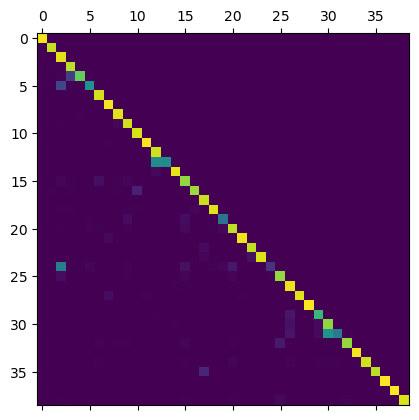

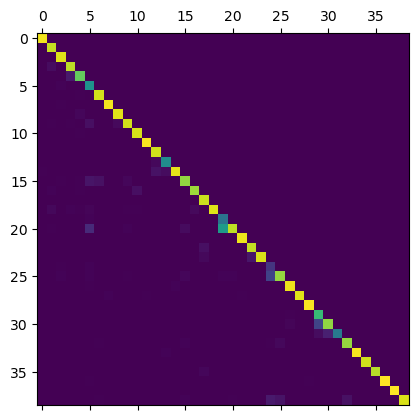

In [24]:
pred_df = pd.concat(pred_means).reset_index().groupby(["y_true", "variable"]).mean()
pred_dist = pred_df.unstack().values
pred_dist_lower = np.tril(pred_dist)
pred_dist_upper = np.triu(pred_dist).T
plt.matshow(pred_dist_lower)
plt.matshow(pred_dist_upper)

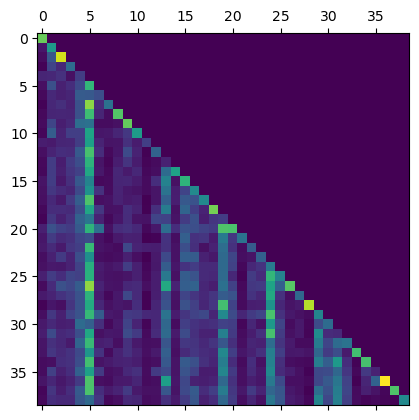

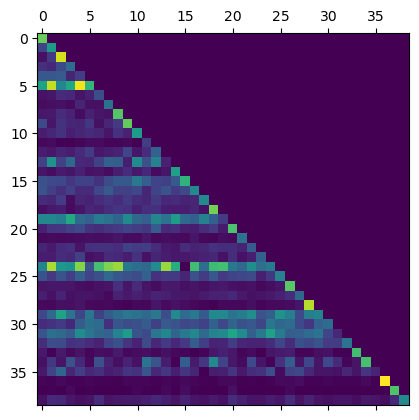

In [25]:
H_dist = pd.DataFrame(H_means).sort_index()
H_dist_lower = np.tril(H_dist)
H_dist_upper = np.triu(H_dist).T
plt.matshow(H_dist_lower)
plt.matshow(H_dist_upper)

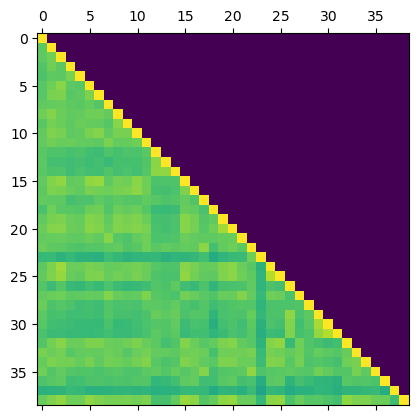

In [26]:
D_lower = np.tril(D)
plt.matshow(D_lower)

C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:2: RuntimeWarning: divide by zero encountered in log
  x = np.log(pred_dist_lower.ravel())
C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:9: RuntimeWarning: divide by zero encountered in log
  x = np.log(pred_dist_upper.ravel())
C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(H_dist_lower.ravel())
C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:21: RuntimeWarning: divide by zero encountered in log
  x = np.log(H_dist_upper.ravel())


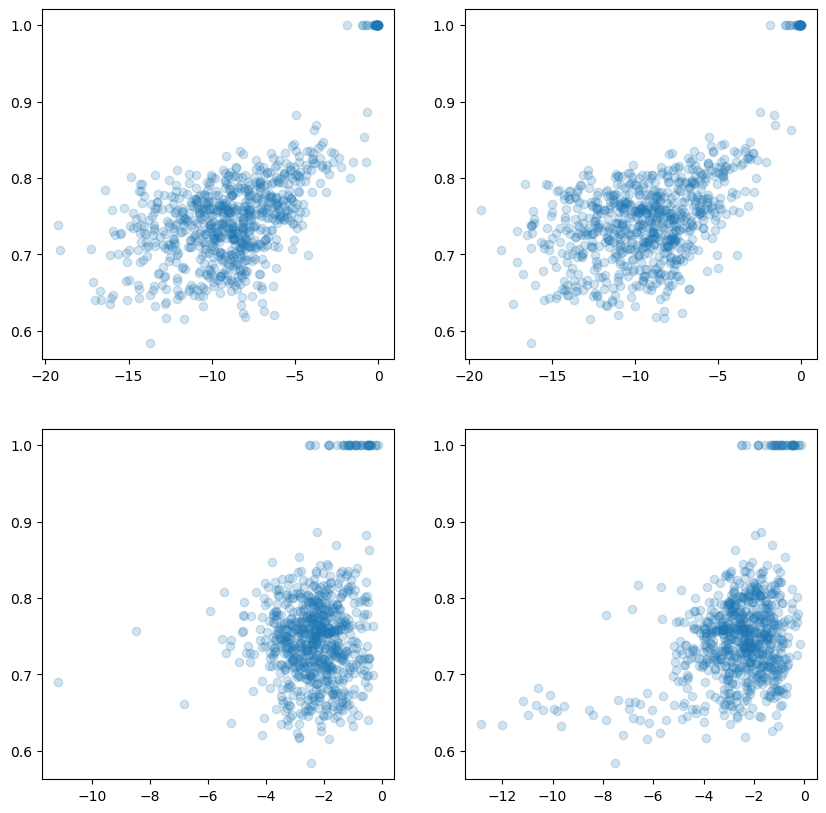

In [42]:
fig,ax =plt.subplots(2,2,figsize=(10,10))
x = np.log(pred_dist_lower.ravel())
y = D_lower.ravel()
ax[0][0].scatter(x,
            y,
            alpha=0.2
            )

x = np.log(pred_dist_upper.ravel())
ax[0][1].scatter(x,
            y,
            alpha=0.2
            )

x = np.log(H_dist_lower.ravel())
ax[1][0].scatter(x,
            y,
            alpha=0.2
            )

x = np.log(H_dist_upper.ravel())
ax[1][1].scatter(x,
            y,
            alpha=0.2
            )

In [43]:
from sklearn.metrics import confusion_matrix

In [81]:
top3_df = []
for label, model_name in zip(config["labels"], config["ckpts"]):
    print(label)
    df_pred, n_col = load_data(label, model_name)

    # Pred means
    taxa = df_pred.columns[2:-1]
    assert len(taxa) == 39

    cm = confusion_matrix(df_pred.y_true, df_pred.y_pred, labels=taxa,normalize="true")
    assert cm.shape == (39,39)

    outlier_preds = cm[0]
    ind = np.argsort(outlier_preds)[::-1][:3]
    top3 = taxa[ind]
    top3_p = outlier_preds[ind]
    top3_dna = D.loc[label][top3].values
    top3_dna_rank = D.loc[label].argsort()[top3].values

    top3_df.append(pd.DataFrame({"outlier":label,
                "rank": np.arange(1,4),
                "taxa": top3,
                "pred_p": top3_p,
                "DNA_dist": top3_dna,
                "DNA_rank": top3_dna_rank})
    )

Agapetus_sp
Ameletus_inopinatus
Amphinemura_borealis
Baetis_rhodani
Baetis_vernus_group
Capnopsis_schilleri
Diura_sp
Elmis_aenea
Ephemerella_aurivillii
Ephemerella_mucronata
Heptagenia_sulphurea
Hydraena_sp
Hydropsyche_pellucidula
Hydropsyche_saxonica
Hydropsyche_siltalai
Isoperla_sp
Kageronia_fuscogrisea
Lepidostoma_hirtum
Leptophlebia_sp
Leuctra_nigra
Leuctra_sp
Limnius_volckmari
Micrasema_gelidum
Micrasema_setiferum
Nemoura_cinerea
Nemoura_sp
Neureclipsis_bimaculata
Oulimnius_tuberculatus
Oxyethira_sp
Plectrocnemia_sp
Polycentropus_flavomaculatus
Polycentropus_irroratus
Protonemura_sp
Rhyacophila_nubila
Sialis_sp
Silo_pallipes
Simuliidae
Sphaerium_sp
Taeniopteryx_nebulosa


In [91]:
top3 = pd.concat(top3_df).reset_index(drop=True)
top3 = top3.pivot(index="outlier",columns="rank",values=["taxa", "pred_p", "DNA_dist", "DNA_rank"]).stack()
top3 = top3.astype({"pred_p": np.float64,
             "DNA_dist": np.float64,
             "DNA_rank": float})
top3

taxa    pred_p  DNA_dist  \
outlier               rank                                                
Agapetus_sp           1        Hydropsyche_siltalai  0.305971  0.744681   
                      2     Neureclipsis_bimaculata  0.197887  0.734043   
                      3          Lepidostoma_hirtum  0.152082  0.759878   
Ameletus_inopinatus   1              Baetis_rhodani  0.577687  0.782675   
                      2             Leptophlebia_sp  0.242357  0.779635   
...                                             ...       ...       ...   
Sphaerium_sp          2                  Simuliidae  0.249856  0.620061   
                      3     Hydropsyche_pellucidula  0.167917  0.633739   
Taeniopteryx_nebulosa 1              Protonemura_sp  0.435283  0.828267   
                      2                  Nemoura_sp  0.395100  0.832827   
                      3                 Isoperla_sp  0.065605  0.844985   

                            DNA_rank  
outlier               rank            
Agapetus_sp           1         14.0  
                      2         10.0  
                      3         13.0  
Ameletus_inopinatus   1         26.0  
                      2         33.0  
...                              ...  
Sphaerium_sp          2         22.0  
                      3          0.0  
Taeniopteryx_nebulosa 1         19.0  
                      2         11.0  
                      3          0.0  

[117 rows x 4 columns]

In [92]:
import plotly.express as px
px.scatter(top3.reset_index(),
           x="pred_p",
           y="DNA_dist",
           color="DNA_rank",
           hover_data=["outlier", "taxa"],
           width=800,
           height=800)

In [85]:
np.corrcoef(top3.pred_p.values,
            top3.DNA_dist.values)

array([[1.        , 0.29414248],
       [0.29414248, 1.        ]])

In [97]:
np.corrcoef(top3.reset_index()["rank"],
            top3.reset_index().DNA_rank)

array([[ 1.        , -0.15090298],
       [-0.15090298,  1.        ]])

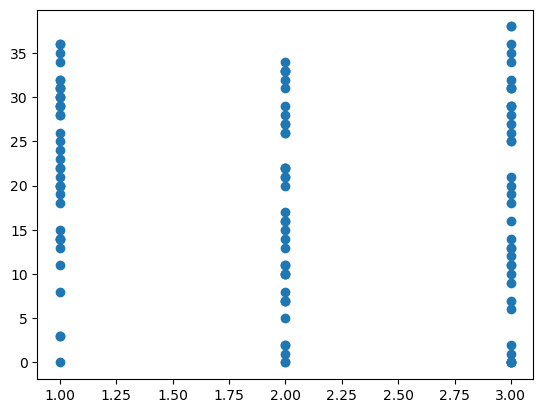

In [98]:
plt.scatter(top3.reset_index()["rank"],
            top3.reset_index().DNA_rank)